<center>

<image src = 'data/main_project_image.jpg'>

</center>

# 1. Чтение и базовая работа с данными

Перед дальнейшей работой импортируем необходимые библиотеки:

In [76]:
# Чтение и работа с данными
import numpy as np
import pandas as pd

# Метод детектирования аномалий
from sklearn.cluster import AgglomerativeClustering

# Визуальный анализ данных
import matplotlib.pyplot as plt
import seaborn as sns

# Разбиение данных на выборки
from sklearn.model_selection import train_test_split

# Реализация байесовской линейной регрессии
import pymc as pm
import arviz as az

# Классическая модель линейной регрессии
from sklearn.linear_model import LinearRegression

# Метрика оценки качества моделей
from sklearn.metrics import mean_absolute_error

# Игнорирование предупреждений
import warnings
warnings.filterwarnings('ignore')

# Визуальная настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

Прочитает полученные для работы данные:

In [77]:
# Читаем данные и задаём столбец-индекс
data = pd.read_csv('data/flats.zip', index_col='Unnamed: 0')

# Проверяем выводом первых строк
data.head()

,price_doc,full_sq,life_sq,num_room,kitch_sq
8056,2750000,11,11.0,1.0,12.0
8154,7100000,45,27.0,2.0,6.0
8287,11700000,77,50.0,3.0,8.0
8387,10400000,56,29.0,2.0,10.0
8391,6200000,31,21.0,1.0,5.0


Проверим данные на наличие возможных пропусков:

In [78]:
# Проверка на пропуски
data.isnull().sum()

price_doc    0
full_sq      0
life_sq      0
num_room     0
kitch_sq     0
dtype: int64

Пропусков нет, можно переходить к разбору статистической характеристики имеющегося набора данных: 

In [79]:
# Статистическая характеристика всего датасета
data.describe()

,price_doc,full_sq,life_sq,num_room,kitch_sq
count,6.042000e+03,6042.000000,6042.000000,6042.000000,6042.000000
mean,8.750423e+06,53.374545,33.198941,1.997021,7.391096
std,6.277290e+06,24.011941,20.190005,0.889523,3.806198
min,5.000000e+05,1.000000,0.000000,0.000000,0.000000
25%,5.800000e+06,38.000000,20.000000,1.000000,5.000000
50%,7.400000e+06,46.000000,29.000000,2.000000,7.000000
75%,1.050000e+07,63.000000,42.000000,3.000000,9.000000
max,9.512250e+07,637.000000,637.000000,17.000000,96.000000


Из полученной информации мы можем сделать следующие выводы касательно наших дынных:

* Во-первых наша целевая переменная `'price_doc'` явно нуждается в логарифмическом масштабе в виду огромного разброса значений, это упростит её дальнейший анализ и поможет нашим моделям с будущими прогнозами.

  Также, если обратить внимание на сам разброс можно легко сделать выводы о наличии аномально огромных значениях в стоимости помещений (**вплоть до 95.122 миллионов за помещение!**) что в свою очередь указывает о необходимости в поиске и удалении аномальных значений.

* Во-вторых, если говорить о выбросах, у нас также имеются помещения как с огромными, так и крохотными площадями при среднем значении признака `'full_sq'` в $54м^2$, что также требует в детектировании и избавлении от возможных выбросов.

Начнём по порядку, с возведением целевой переменной в логарифмический масштаб:

In [80]:
# Для удобства создаём новый признак
data['price_doc_log'] = np.log(data['price_doc'])

Теперь приступим к выявлению выбросов в ценах на помещения.

Воспользуемся методом агломеративной кластеризацией, проверим наш признак на аномальные значения и избавимся от них:

In [81]:
# Создаём объект класса AgglomerativeClustering
agglom = AgglomerativeClustering(n_clusters=None, distance_threshold=1)

# Находим выбросы в цене по заданным параметрам
data['prediction_agglom'] = agglom.fit_predict(data['price_doc'].values.reshape(-1, 1))
valcount = data['prediction_agglom'].value_counts()
valcount = set(valcount[valcount == 1].index)

# Выведем найденные выбросы
print(f'Метод AgglomerativeClustering нашёл: {data[data.prediction_agglom.isin(valcount)].shape[0]} аномалий')

Метод AgglomerativeClustering нашёл: 716 аномалий


Аномальные цены найдены, избавимся от них не забыв и об аномальных площадях:

In [82]:
# Выбросы найденные методом агломеративной кластеризацией
data = data.drop(data[data.prediction_agglom.isin(valcount)].index)

# Временный столбец созданный при поиске выбросов
data = data.drop('prediction_agglom', axis=1)

# Единичные случаи огромных помещений
data = data.drop(data[data['life_sq'] > 150].index, axis=0)

# Единичные случаи крохотных помещений
data = data.drop(data[data['life_sq'] < 5].index, axis=0)

Когда выбросы были удалены, посмотрим на статистическую характеристику данных ещё раз:

In [83]:
# Статистическая характеристика очищенного датасета
data.describe()

,price_doc,full_sq,life_sq,num_room,kitch_sq,price_doc_log
count,5.324000e+03,5324.000000,5324.000000,5324.000000,5324.000000,5324.000000
mean,8.227158e+06,51.021788,31.038317,1.984786,7.426559,15.732285
std,5.259864e+06,19.360640,13.557873,0.868140,3.176985,0.674110
min,9.900000e+05,11.000000,7.000000,0.000000,0.000000,13.805460
25%,5.800000e+06,38.000000,20.000000,1.000000,5.000000,15.573368
50%,7.250000e+06,45.000000,29.000000,2.000000,7.000000,15.796512
75%,1.000000e+07,59.000000,39.000000,3.000000,9.000000,16.118096
max,6.500000e+07,216.000000,145.000000,17.000000,74.000000,17.989898


Наш датасет стал выглядеть куда лучше, у нас больше нет записей со стоимостью граничащей с сотней миллионов и гигантскими пощадами, как и нулевыми, следовательно, можно приступать к следующему этапу нашей работы.

# 2. Визуальный анализ данных

На данном этапе мы проведём визуализацию распределения целевой переменной в логарифмическом масштабе от имеющихся признаков.

Мы оценим их влияние на ценообразование и их корреляцию между собой чтобы определить необходимость их наличия при обучении моделей.

## 2.1 Распределение целевой переменной от площади помещения

Начнём с информации о площадях помещений. Для удобства визуализации мы проведём следующие действия перед построением графиков:

1. Создадим 3 отдельных датасета сгруппировав цены по имеющимся площадям.

2. Найдём средние значения целевой переменной в логарифмическом масштабе (`'price_doc_log'`) для каждой из площадей.

3. Восстановим индексы после группировки для их передачи в параметры визуализации.

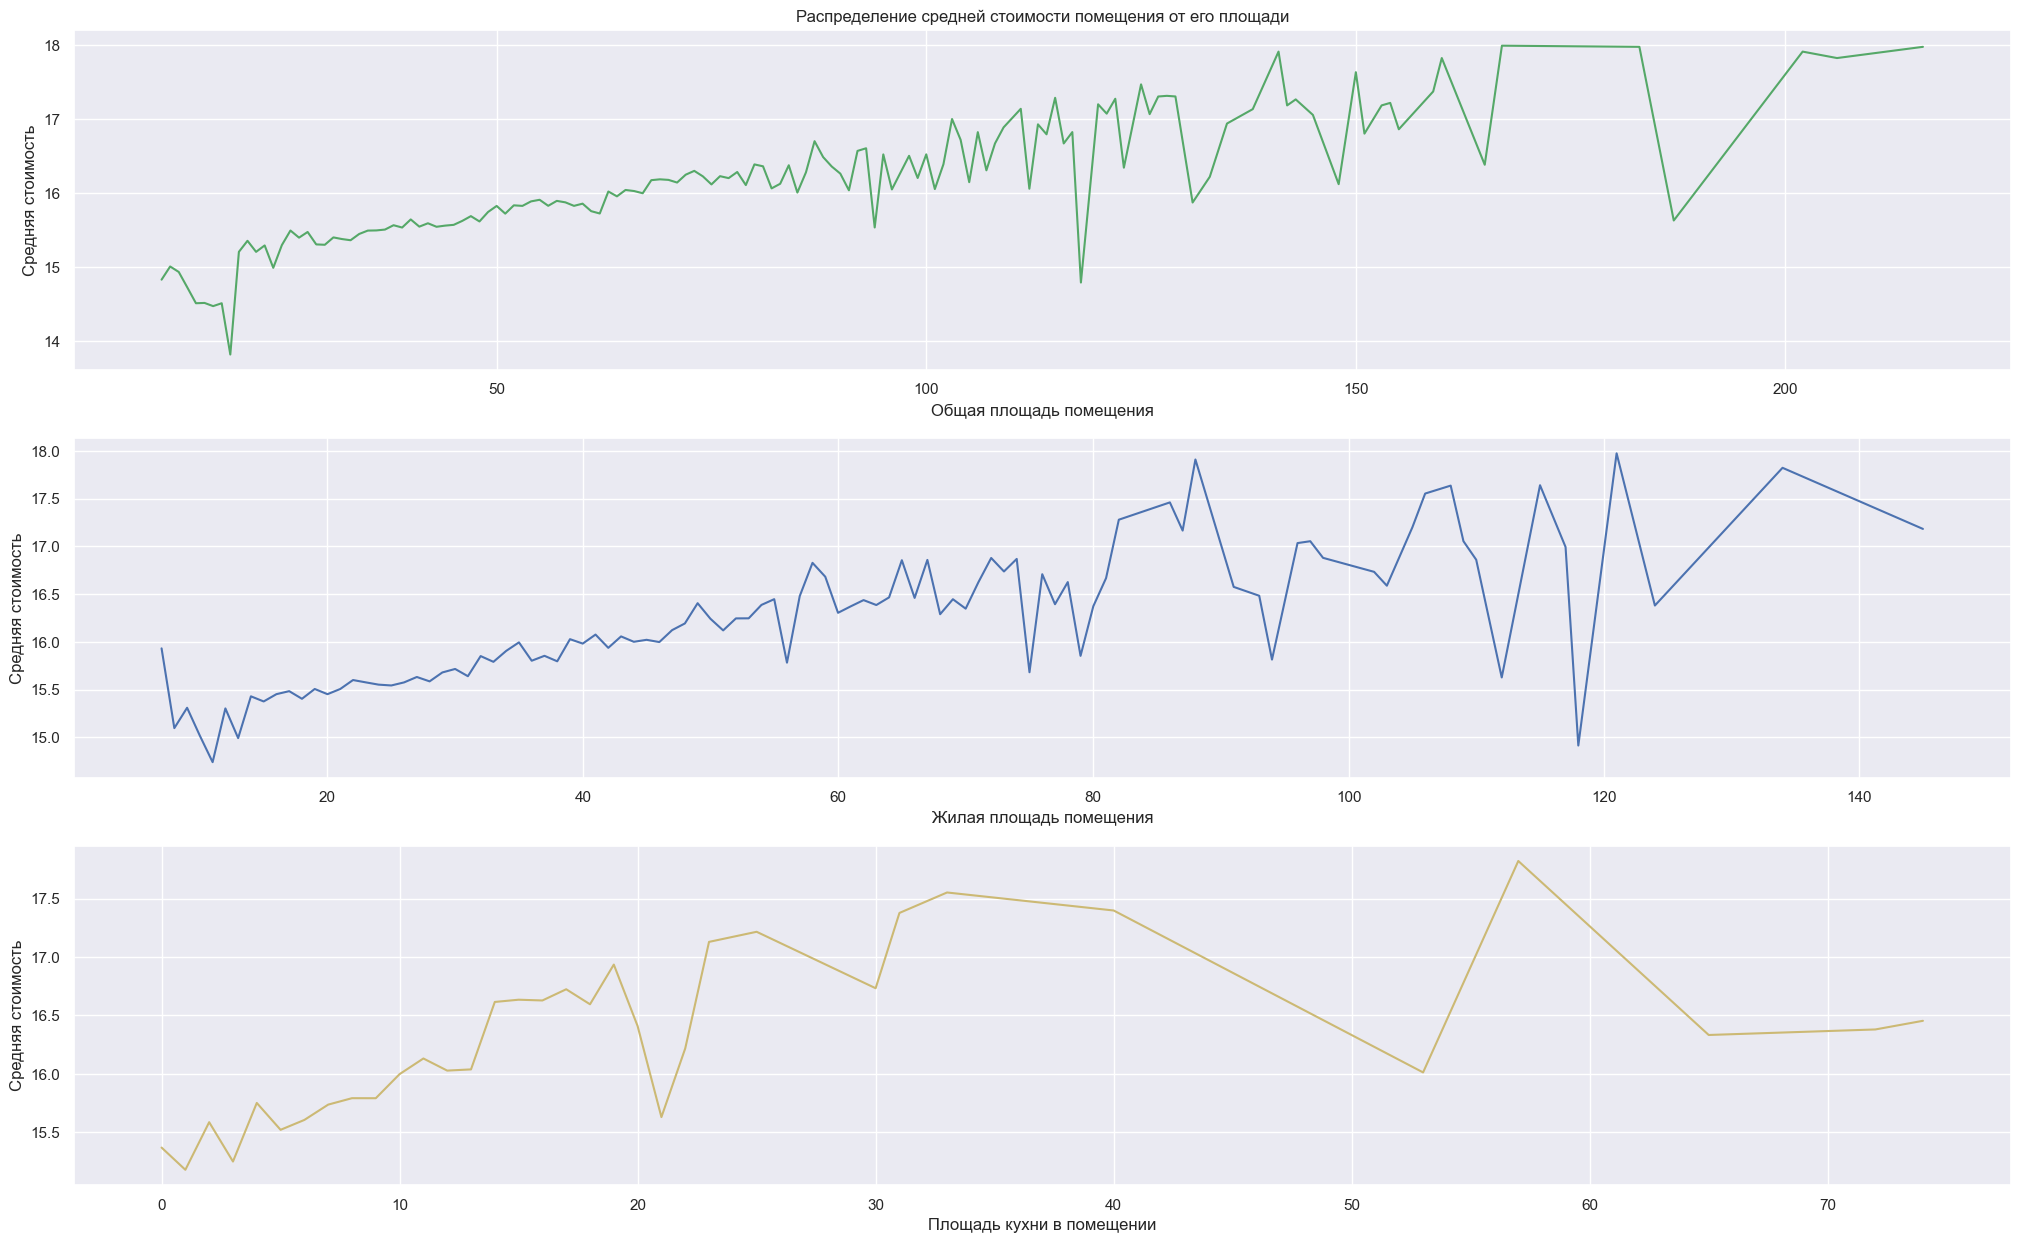

In [84]:
# 1. Создаём 3 отдельных датасета для визуализации 
price_by_full_sq = data.groupby('full_sq')['price_doc_log'].mean().to_frame().reset_index() # 2. Находим средние значения и восстанавливаем индексы
price_by_life_sq = data.groupby('life_sq')['price_doc_log'].mean().to_frame().reset_index()
price_by_kitch_sq = data.groupby('kitch_sq')['price_doc_log'].mean().to_frame().reset_index()

# 3. Визуализируем полученный результат
fig, axes = plt.subplots(3, 1, figsize=(25, 15))

# Для датасета с общей площадью 
line_plot = sns.lineplot(data=price_by_full_sq,
                         x='full_sq',
                         y='price_doc_log',
                         color='g',
                         ax=axes[0])
axes[0].set(xlabel = 'Общая площадь помещения', ylabel = 'Средняя стоимость')
axes[0].set_title('Распределение средней стоимости помещения от его площади')

# Для датасета с жилой площадью 
line_plot = sns.lineplot(data=price_by_life_sq,
                         x='life_sq',
                         y='price_doc_log',
                         color='b',
                         ax=axes[1])
axes[1].set(xlabel = 'Жилая площадь помещения', ylabel = 'Средняя стоимость')

# Для датасета с площадью кухни
line_plot = sns.lineplot(data=price_by_kitch_sq,
                         x='kitch_sq',
                         y='price_doc_log',
                         color='y',
                         ax=axes[2])
axes[2].set(xlabel = 'Площадь кухни в помещении', ylabel = 'Средняя стоимость');

Распределения визуализированы, посмотрим поближе на имеющиеся значения в каждой из группировок:   

In [85]:
# Данные об общей площади и средней цене 
price_by_full_sq.sort_values('price_doc_log', ascending=False)

,full_sq,price_doc_log
133,167,17.989898
134,183,17.974394
138,216,17.974394
120,141,17.909855
136,202,17.909855
...,...,...
5,16,14.512773
4,15,14.508658
7,18,14.508658
6,17,14.469677


In [86]:
# Данные о жилой площади и средней цене 
price_by_life_sq.sort_values('price_doc_log', ascending=False)

,life_sq,price_doc_log
96,121.0,17.974394
78,88.0,17.909855
98,134.0,17.822844
93,115.0,17.640357
89,108.0,17.636295
...,...,...
1,8.0,15.096444
3,10.0,15.016974
6,13.0,14.991817
95,118.0,14.914123


In [87]:
# Данные об площади кухни и средней цене 
price_by_kitch_sq.sort_values('price_doc_log', ascending=False)

,kitch_sq,price_doc_log
30,57.0,17.822844
27,33.0,17.553180
28,40.0,17.399029
26,31.0,17.377976
24,25.0,17.216708
23,23.0,17.130229
19,19.0,16.935891
25,30.0,16.733385
17,17.0,16.724607
15,15.0,16.635142


Как мы можем видеть, очистка данных из предыдущего этапа дала свои плоды — не смотря на то, что в наших данных всё ещё есть единичные наблюдения, они почти не выбиваются из общей массы и не контрастируют на их фоне. Мы конечно могли бы избавиться и от них, но это было бы избыточным.

Так же стоит обратить внимание на само ценообразование, если признаки характеризующие общую и жилую площадь (`'full_sq'` и `'life_sq'` соответственно) заметно влияют на стоимость помещения, то о признаке площади кухни (`'kitch_sq'`) наверняка это сказать сложно, ведь как мы наблюдали цена на помещения с большей площадью кухни может быть как выше, так и сильно ниже уровня помещений с площадью меньше. Возможно, это первый кандидат на отсечение из обучающих предикторов.

## 2.2 Распределение целевой переменной от жилых комнат

Визуализируем оставшийся признак характеризующий количество комнат в помещении (`'num_room'`).

В целях удобства визуализации проведём те же манипуляции что и с предыдущими тремя признаками и оценим результат:

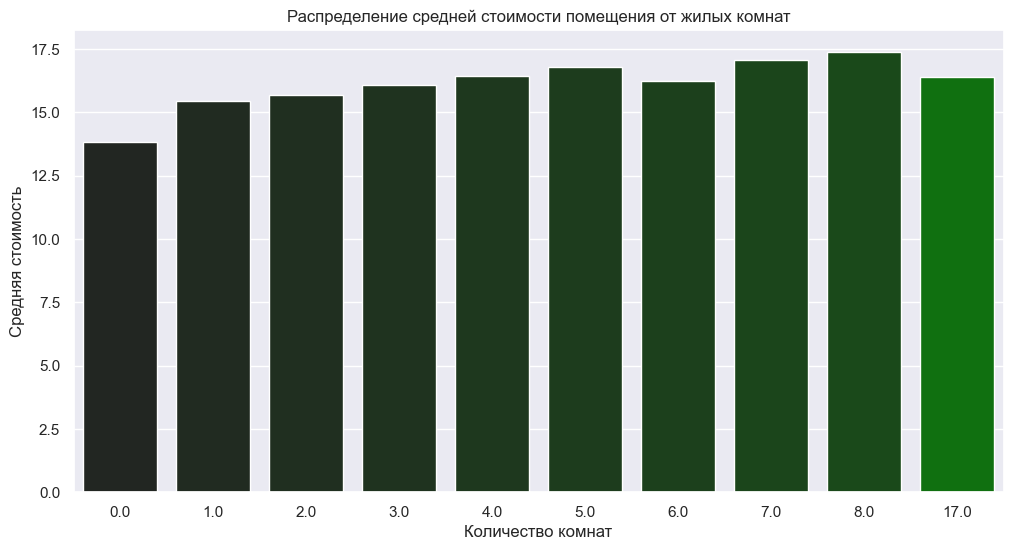

In [88]:
# 1. Создаём отдельный датасет для визуализации 
price_by_room_count = data.groupby('num_room')['price_doc_log'].mean().to_frame().reset_index() # 2. Находим средние значения и восстанавливаем индексы

# 3. Визуализируем полученный результат
plt.figure(figsize=(12, 6))

bar_plot = sns.barplot(data=price_by_room_count,
                       x='num_room',
                       y='price_doc_log',
                       hue='num_room',
                       palette='dark:green',
                       legend=False)
bar_plot.set(xlabel='Количество комнат', ylabel='Средняя стоимость')
bar_plot.set_title('Распределение средней стоимости помещения от жилых комнат');

Оценим значения подробнее:

In [89]:
# Данные о количестве комнат и средней цене 
price_by_room_count.sort_values('price_doc_log', ascending=False)

,num_room,price_doc_log
8,8.0,17.370859
7,7.0,17.054189
5,5.0,16.782488
4,4.0,16.436393
9,17.0,16.391932
6,6.0,16.222415
3,3.0,16.059794
2,2.0,15.701830
1,1.0,15.458806
0,0.0,13.815511


Как и в случае с площадью кухни сложно сказать наверняка о целесообразности в наличии признака `'num_room'` в наборе, ведь как мы можем наблюдать, увеличение количества комнат так же оказывает слабое влияние на повышение средней стоимости помещений, а в некоторых отдельных случаях, как в избыточных 17 комнатах и вовсе является фактором уменьшения средней цены.

## 2.3 Матрица корреляции признаков с целевой переменной

Когда с распределения разобрались оценим матрицу корреляции признаков с целевой переменной и между друг другом:

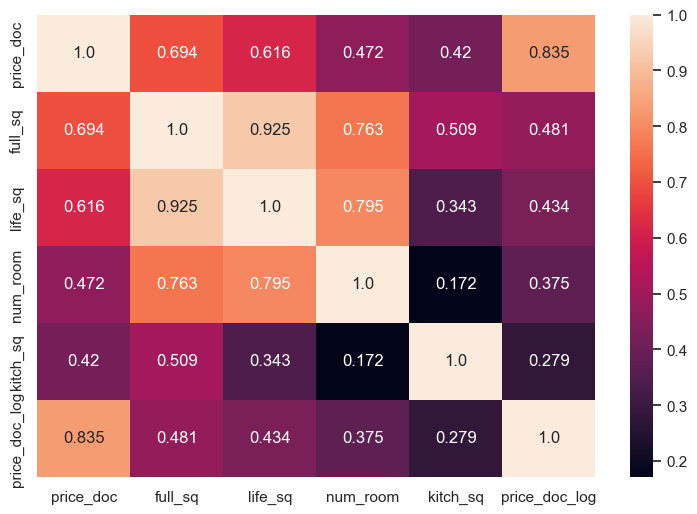

In [90]:
# Создаём матрицу корреляции признаков
corr = data.corr()

# Визуализируем полученную матрицу
fig = plt.figure(figsize=(9, 6))

sns.heatmap(corr, annot=True, fmt='.3');

В общем случае мы были правы касательно признаков `'num_room'` и `'kitch_sq'`, они имеют самый маленький коэффициент корреляции с нашей целевой переменной, однако признак количества комнат (`'num_room'`) имеет очевидную наивысшую связь с признаками общей и жилой площади (`'full_sq'` и  `'life_sq'` соответственно), в отличие от `'kitch_sq'`, имеющего самые низкие показатели корреляции с остальными признаками из обучающего набора.

Следовательно, мы избавимся от последнего, ведь такая слабая корреляция может только добавить шум при обучении наших моделей.

# 3. Базовая модель байесовской линейной регрессии

Начнём с модели байесовской линейной регрессии.

Обучим нашу модель на тестовых данных, сделаем предсказание и оценим полученный результат метрикой `MAE — средней абсолютной ошибкой`:

<center>

${MAE} = \frac{1}{N} \sum_{i=1}^{N} |Actual_i - Predicted_i|$

</center>

In [91]:
# Задаём наши предикторы и целевую переменную для обучения
X = data.drop(['price_doc_log', 'price_doc', 'kitch_sq'], axis=1)
y = data['price_doc']

# Разделяем данные на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=42)

# Явно указываем предикторы
predictors = ['full_sq', 'life_sq', 'num_room']

# Задаём значения предикторов и целевой переменной в логарифмическом масштабе
X = X_train.values
y = y_train
y_log = np.log(y)

# Задаём параметры модели
with pm.Model() as regression_model:
    # Коэффициенты с их именами
    coefs = pm.Normal('coefs', mu=0, sigma=100, shape=len(predictors), dims='predictors')
    intercept = pm.Normal('intercept', mu=0, sigma=100)
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Назначаем имена переменных для будущих коэффициентов
    pm.Deterministic('full_sq', coefs[0])
    pm.Deterministic('life_sq', coefs[1])
    pm.Deterministic('num_room', coefs[2])
    
    # Реализуем модель
    mu = pm.math.dot(X, coefs) + intercept
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_log)
    
    trace = pm.sample(2000, tune=1000, target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coefs, intercept, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.


Модель обучена, можно оценить значения полученных коэффициентов:

In [92]:
# Анализ результатов коэффициентов
az.summary(trace, var_names=['full_sq', 'life_sq', 'num_room', 'intercept', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
full_sq,0.018,0.002,0.014,0.021,0.000,0.000,3820.0,4052.0,1.0
life_sq,-0.005,0.003,-0.010,0.001,0.000,0.000,4005.0,4407.0,1.0
num_room,0.032,0.029,-0.023,0.087,0.000,0.000,4986.0,4849.0,1.0
intercept,14.924,0.042,14.844,15.004,0.001,0.001,5316.0,4806.0,1.0
sigma,0.601,0.011,0.581,0.621,0.000,0.000,5912.0,4444.0,1.0


По результатам коэффициентов видно, что при обучении модель уделяла большее внимание признакам характеризующих общую площадь помещения (`'full_sq'`) и количество комнат (`'num_room'`), и меньшее внимание жилой площади (`'life_sq'`).

Сделаем предсказание для тестового набора данных:

In [93]:
# Указываем значения коэффициентов и константы
coefs_mean = trace.posterior['coefs'].mean(dim=('chain', 'draw')).values
intercept_mean = trace.posterior['intercept'].mean(dim=('chain', 'draw')).values

# Выбираем значения X_test по выбранным признакам
X_test_new = X_test[predictors].values

# Делаем предсказание логарифма цены 
log_pred = np.dot(X_test_new, coefs_mean) + intercept_mean

# Проводим обратное логарифмирование, чтобы получить прогноз цены
pred_price = np.exp(log_pred)

# Указываем реальные цены для метрики оценки качества прогноза
true_price = y_test.values

# Вычисляем и выводим полученную метрику
mae = mean_absolute_error(true_price, pred_price)
print('Mean Absolute Error:', mae)

Mean Absolute Error: 2619190.2075757487


Результат модели мягко говоря неутешительный, при средней ошибке в 2617830.75 единиц местной валюты и средним значением из тестовой выборки в 8157459.40 единиц можно сделать вывод что наша базовая модель ошибается в среднем на 32.1%, что является довольно высоким порогом, требующим доработку.

Сравним полученные результаты с классической моделью линейной регрессии.

# 4. Базовая модель классической линейной регрессии 

Обучим модель классической линейной регрессии с базовыми параметрами на тех же данных. Мы так же сделаем прогноз и сверим полученный результат с тем, что мы видели ранее:

In [94]:
# Создаём объект класса LinearRegression с базовыми параметрами
lr_model = LinearRegression()

# Обучаем модель на наших предикторах и целевой переменной в логарифмическом масштабе
lr_model.fit(X_train, np.log(y_train))

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Сверим полученное значение константы с моделью байесовской линейной регрессии:

In [95]:
# Получаем значение константы
lr_model.intercept_

np.float64(14.923064073894942)

Так же не забудем и о значениях коэффициентов для признаков:

In [96]:
# Задаём наименования обучающих признаков
features = ['full_sq', 'life_sq', 'num_room']

# Находим их коэффициенты модели
coefficients = lr_model.coef_

# Для удобства создаем из полученных данных DataFrame
coef_df = pd.DataFrame(coefficients, index=features, columns=['Коэффициент'])
coef_df

,Коэффициент
full_sq,0.017603
life_sq,-0.004996
num_room,0.031971


Значения полученных коэффициентов крайне похожи, следовательно, наша модель классической линейной регрессии даст близкий к предыдущей модели результат. 

Убедимся в этом сделав предсказание для тестовой выборки и рассчитав метрику *MAE*:

In [97]:
# Делаем предсказание логарифмической цены для тестовой выборки
log_pred = lr_model.predict(X_test)

# Проводим обратное логарифмирование
y_pred = np.exp(log_pred)

# Рассчитываем и выводим метрику оценки качества прогноза
mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
print(f"MAE: {mae}")

MAE: 2618465.5899962294


Как мы и предполагали, результаты ошибок базовой модели линейной регрессии так же высоки как и в случае с байесовской моделью, что не удивительно, ведь обе модели регрессии делают относительно аналогичные расчёты при прогнозе нашей целевой переменной.

Модель также требует дальнейшем доработки для получения меньшей ошибки, но её также можно использовать в виде базовой модели.

# 5. Общий вывод по исследованию

После проведённой работы над имеющимися данными мы сравнили два подхода в модели линейной регрессии в области ценообразования помещений, получив уровень ошибки *MAE* примерно на треть от среднего значения тестовой выборки — это неплохо, особенно когда имеющиеся цены варьируются в широком диапазоне. 

Однако, есть несколько моментов, которые стоит учитывать:

* Цены на объекты очень разные и вариативные, MAE в размере около 2,69 млн при среднем в 8,2 млн может считаться оправданным, особенно если точность будет требовать в дальнейшем более локальных оценок.

* Если для принятия решений важна точность в пределах нескольких сотен тысяч, то такой уровень ошибки может быть слишком высоким. В таком случае стоит дальше работать над улучшением одной из выбранных моделей.

Таким образом, наш текущий результат — это хороший старт, особенно в сложной задаче ценообразования. Но вполне очевидно, что есть потенциал для улучшения, например, за счет добавления большего количества признаков, более сложных моделей или методов обработки данных.